# MNIST

The **MNIST** database (Modified National Institute of Standards and Technology database) is a large collection of **handwritten digits**. It has a **training** set of **60,000** examples, and a **test** set of **10,000** examples. 

The digits have been size-normalized and centered in a fixed-size image. The original black and white (bilevel) images from NIST were size normalized to fit in a **20x20** pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. 

The images were centered in a **28x28** image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

*Wiki*: *https://paperswithcode.com/dataset/mnist*, 

*Data source*: *https://www.kaggle.com/competitions/digit-recognizer/data?select=test.csv*

## **Chapter 1**

### Import libraries

In [123]:
# Data manipulation
import pandas as pd
import numpy as np
import itertools

# Data visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Libraries from Scikit-learn & Keras, to help with the ML part - We are using TF backend
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Dask is a flexible library for parallel computing in Python. - https://docs.dask.org/en/stable/
# import dask
# !pip install fsspec
import dask.dataframe as dd

# See all the features in the head() function
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.style.use("ggplot") # Make matplotlib charts looks like ggplot from R.

In [ ]:
# Download MNIST dataset directly from Kaggle competition
"""
1. Make a directory named “.kaggle”
2. Copy the “kaggle.json” into this new directory - This one is created from Kaggle account --> Create new API token
3. Allocate the required permission
4. Download ZIP file from Kaggle
5. Unzip the file to obtain, Train.csv & Test.csv
"""
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download digit-recognizer
# !unzip digit-recognizer.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 59% 9.00M/15.3M [00:00<00:00, 43.8MB/s]
100% 15.3M/15.3M [00:00<00:00, 56.6MB/s]
Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

In [ ]:
# Shape of train, test data
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

## **Chapter 2**
### Exploratory Data Analysis (EDA)

**Exploratory Data Analysis** refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.


In [ ]:
# Shape of train, test data
print(f" Null values on Train set: {df_train.isna().any().sum()}")
print(f" Null values on Test set: {df_test.isna().any().sum()}")#df_test.isnull().any().describe()

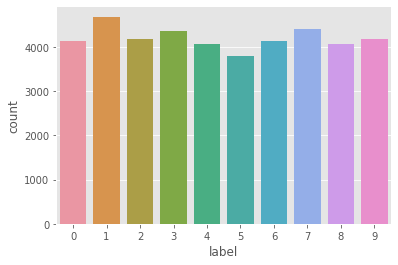

In [ ]:
# Data Processing to feed into the Model - Normalize & reshape values
"""
1. We split our data to x_train, x_test, y_train, y_test
2. We normalize the values of pixels with the largest 255 (white)
"""
y_train = df_train["label"]
x_train = df_train.drop(labels = ["label"],axis = 1)

g = sns.countplot(x = y_train)

# y_train.value_counts()

# Grayscale normalization to reduce the effect of illumination's differences. CNN converge faster on [0 - 1] rathen on [0 - 255]
x_train = x_train / 255.0
x_test = df_test / 255.0

# Reshape to 28x28x1 3D matrices
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

# Encode labels to one hot vectors
y_train = to_categorical(y_train, num_classes = 10)

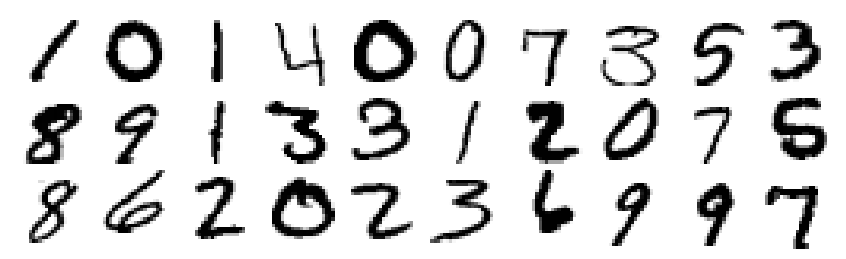

In [ ]:
# Visualization of train set
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(x_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# **Chapter 3**
### Machine Learning (ML) model & architectures

### 1. Train/Validation set

In [ ]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state= 2)

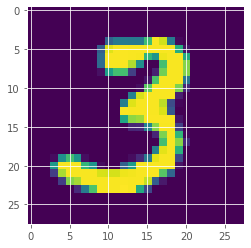

In [ ]:
# Visualization example of training data
plt.imshow(X_train[6][:,:,0])
plt.show()

### Optional - Data Augmentation

In [ ]:
# Data Augmentation - Avoid overfitting problem

"""
We can make your existing dataset larger, with synthetic (augmented) data. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques.
Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

For this example, we cannot use vertical or horizontal flip, as it could lead to misclassification of symmetrical numbers like 6,9
"""
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

## ***Convolutional Neural Networks (CNN) | Overview***

There are so many different CNN architectures (AlexNet, LeNet-5, Inception-v1-3, VGG-16 etc.) that were used for experimentation. 

But, how do we choose the most accurate and efficient CNN architecture for classifying MNIST handwritten digits?

A typical CNN design begins with feature extraction (alternating convolution layers with subsampling layers) and finishes with classification (dense layers followed by a final softmax layer).


### Model

1. Convolutional (Conv2D) layer with **32** filters for the two first conv2D layers and **64** filters for the last two ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a **transformation** of the image.

2. Max Pooling (**MaxPool2D**) layer. This layer simply acts as a **downsampling** filter. The use of them is to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

3. **Dropout** is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way.

4. Activation function = '**ReLu**'. The rectifier activation function is used to add non linearity to the network.

5. Flatten layer to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers.

6. 2 Fully Connected (FC) dense layers which are neural networks (ANN) classifier. **Softmax** has been used as the activation function for the last layer, in order to distribute the probability of the 10 outputs.

In [ ]:
model = Sequential()

# 1st Block
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', kernel_initializer = 'he_normal',
                 activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', kernel_initializer = 'he_normal',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))

# 2nd Block
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal',
                 activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# 3rd Block
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_137 (Conv2D)         (None, 28, 28, 32)        832       
                                                                 
 conv2d_138 (Conv2D)         (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_69 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_139 (Conv2D)         (None, 14, 14, 64)        18496     
                                                                 
 conv2d_140 (Conv2D)         (None, 14, 14, 64)        36928     
                                                     

In [ ]:
# Compile the model
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Learning Rate Scheduler
lr_sched = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# Custom Callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(abs(logs.get('val_loss') - (logs.get('loss'))) <= 0.0001):
            print("\n Val Loss is close to train loss so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# Fit the model
batch_size = 64
ep = 30
history = model.fit(datagen.flow(X_train, Y_train, batch_size = batch_size),
                              epochs = ep, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[lr_sched, callbacks])

590/590 - 253s - loss: 0.4374 - accuracy: 0.8589 - val_loss: 0.0609 - val_accuracy: 0.9793 - lr: 0.0010 - 253s/epoch - 429ms/step


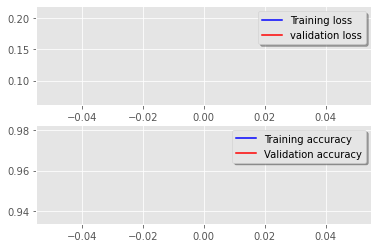

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [121]:
fin_loss, fin_acc = model.evaluate(X_val, Y_val, verbose=2)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(fin_loss, fin_acc))

132/132 - 6s - loss: 0.0609 - accuracy: 0.9793 - 6s/epoch - 44ms/step
Final loss: 0.060926, final accuracy: 0.979286


### Optional - Ensemble CNN architecture

In [ ]:
# 15 CNNs
nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()
    # 1st BLOCK
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    # 2nd BLOCK
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    # 3rd BLOCK - Final Block
    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # Compile the model
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Confusion Matrix

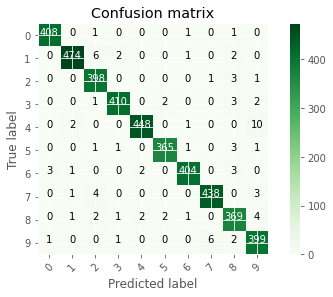

In [127]:
# Look at confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [128]:
# Classification Report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(Y_true_classes, Y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       411
     Class 1       0.99      0.98      0.98       485
     Class 2       0.96      0.99      0.98       403
     Class 3       0.99      0.98      0.98       418
     Class 4       0.99      0.97      0.98       461
     Class 5       0.99      0.98      0.99       372
     Class 6       0.99      0.98      0.98       413
     Class 7       0.98      0.98      0.98       446
     Class 8       0.96      0.97      0.96       382
     Class 9       0.95      0.98      0.96       409

    accuracy                           0.98      4200
   macro avg       0.98      0.98      0.98      4200
weighted avg       0.98      0.98      0.98      4200



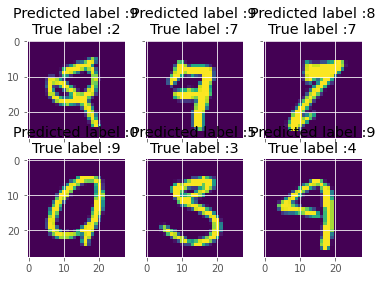

In [ ]:
# Display Error results - We can also classify those errors and insert those misclassified in the train input.

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
# Predict results
results = model.predict(x_test)

# Select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")